# README
**Virtuoso setup**:
- It is assumed that a Virtuoso database has been set up. (A helpful guide to set up Virtuoso on a linux computer can be found here: https://gist.github.com/seralf/8772281).
- We recommend keeping a strict naming convention for your graph names.

**About this notebook**:
- This notebook queries data from a Virtuoso database with numerous graphs using a SPARQL endpoint (in this case the local Virtuoso endpoint). 
- The results from these queries are used to calculate and plot the following metrics:
    - Density, Knowledge Degree, Vocabulary Uniqueness, Vocabulary Dynamicity, Addition Vocabulary Dynamicity, Removal Vocabulary Dynamicity, Change Ratio, Addition Change Ratio, Removal Change Ratio, Growth, Instantiated Class Ratio, Instantiated Property Ratio, Inverse Multiple Inheritance Number, Most Common Subjects, Most Common Predicates and Most Common Objects.

Things you need to do:
- If the endpoint is not the local Virtuoso endpoint the variable "endpoint" needs to be changed to the correct endpoint.
- The graphs, the versions, and their corresponding ontology files (if none then set as None) need to be specified in "Data/notebook.csv".
- The variable graph_name should be set to the name of the graph/organization whose graph is being analyzed. It will only appear in plot titles.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import visualizer as viz
import queries as que
import pywikibot
from SPARQLWrapper import SPARQLWrapper, CSV, JSON

# User defined

In [2]:
endpoint = 'http://localhost:8890/sparql'
graph_csv = pd.read_csv('Data/notebook.csv', sep = ";")
graph_name = 'DBpedia'

# Getting data, running queries and calculations

In [3]:
graph_list = list(graph_csv.File.values)
version_list = (list(graph_csv.Version.values))
ont_list = list(graph_csv.Ont.values)

In [4]:
# Configure the SPARQL endpoint
sparql = SPARQLWrapper(endpoint)

# Configure the SPARQL endpoint and desired return format
sparql.setReturnFormat(JSON)

## Get basics
This function collects the general information needed in calculation throughout the notebook. This includes, the number of triples and the number of distinct subjects, predicates and objects for each version.

In [5]:
que.data_info(sparql, graph_list)

http://example.com/dbpedia_3-5 completed
http://example.com/dbpedia_3-5-1 completed
http://example.com/dbpedia_3-6 completed
http://example.com/dbpedia_3-7 completed
http://example.com/dbpedia_3-8 completed
http://example.com/dbpedia_3-9 completed
http://example.com/dbpedia_2015-04 completed
http://example.com/dbpedia_2015-10 completed
http://example.com/dbpedia_2016-04 completed
http://example.com/dbpedia_2016-10 completed
http://example.com/dbpedia_2019-08 completed
http://example.com/dbpedia_2019-09 completed


## Get structure and content
This function calculates all the structure and content measures for each version. This includes, density, knowledge degree, vocabulary uniqueness, vocabulary dynamicity (also additions and removals), change ratio (also additions and removals) and the growth ratio.

In [6]:
struc_cont = que.structure_and_content(sparql, [graph_list])

In [7]:
struc_cont_data = pd.read_csv('structure_and_content.csv')

## Get quality
This function calculates the quality measures for each version. These measures include, instanciated class ratio, instanciated property ratio and inverse multiple inheritance.

In [8]:
quality = que.quality(sparql, graph_list, ont_list)

In [9]:
quality_data = pd.read_csv('quality.csv')

### Get ipr and icr

In [10]:
que.ipcr_csv(sparql, graph_list, version_list, ont_list, name= 'ipr')
que.ipcr_csv(sparql, graph_list, version_list, ont_list, name= 'icr')

# Top 3 most common
Here we count what the top 3 most common subjects, predicates and objects are for each version of the given graph. The visualization in this section show the percentage of triples in each version that include the most, 2. most or 3. most common entities and properties respectively.

In [11]:
common_dict = que.top_entities('s', wrapper= sparql, graph_list= [graph_list], file_name= 'NotebookOutput/top_sub_.csv')
common_dict = que.top_entities('p', wrapper= sparql, graph_list= [graph_list], file_name= 'NotebookOutput/top_pre_.csv')
common_dict = que.top_entities('o', wrapper= sparql, graph_list= [graph_list], file_name= 'NotebookOutput/top_obj_.csv')

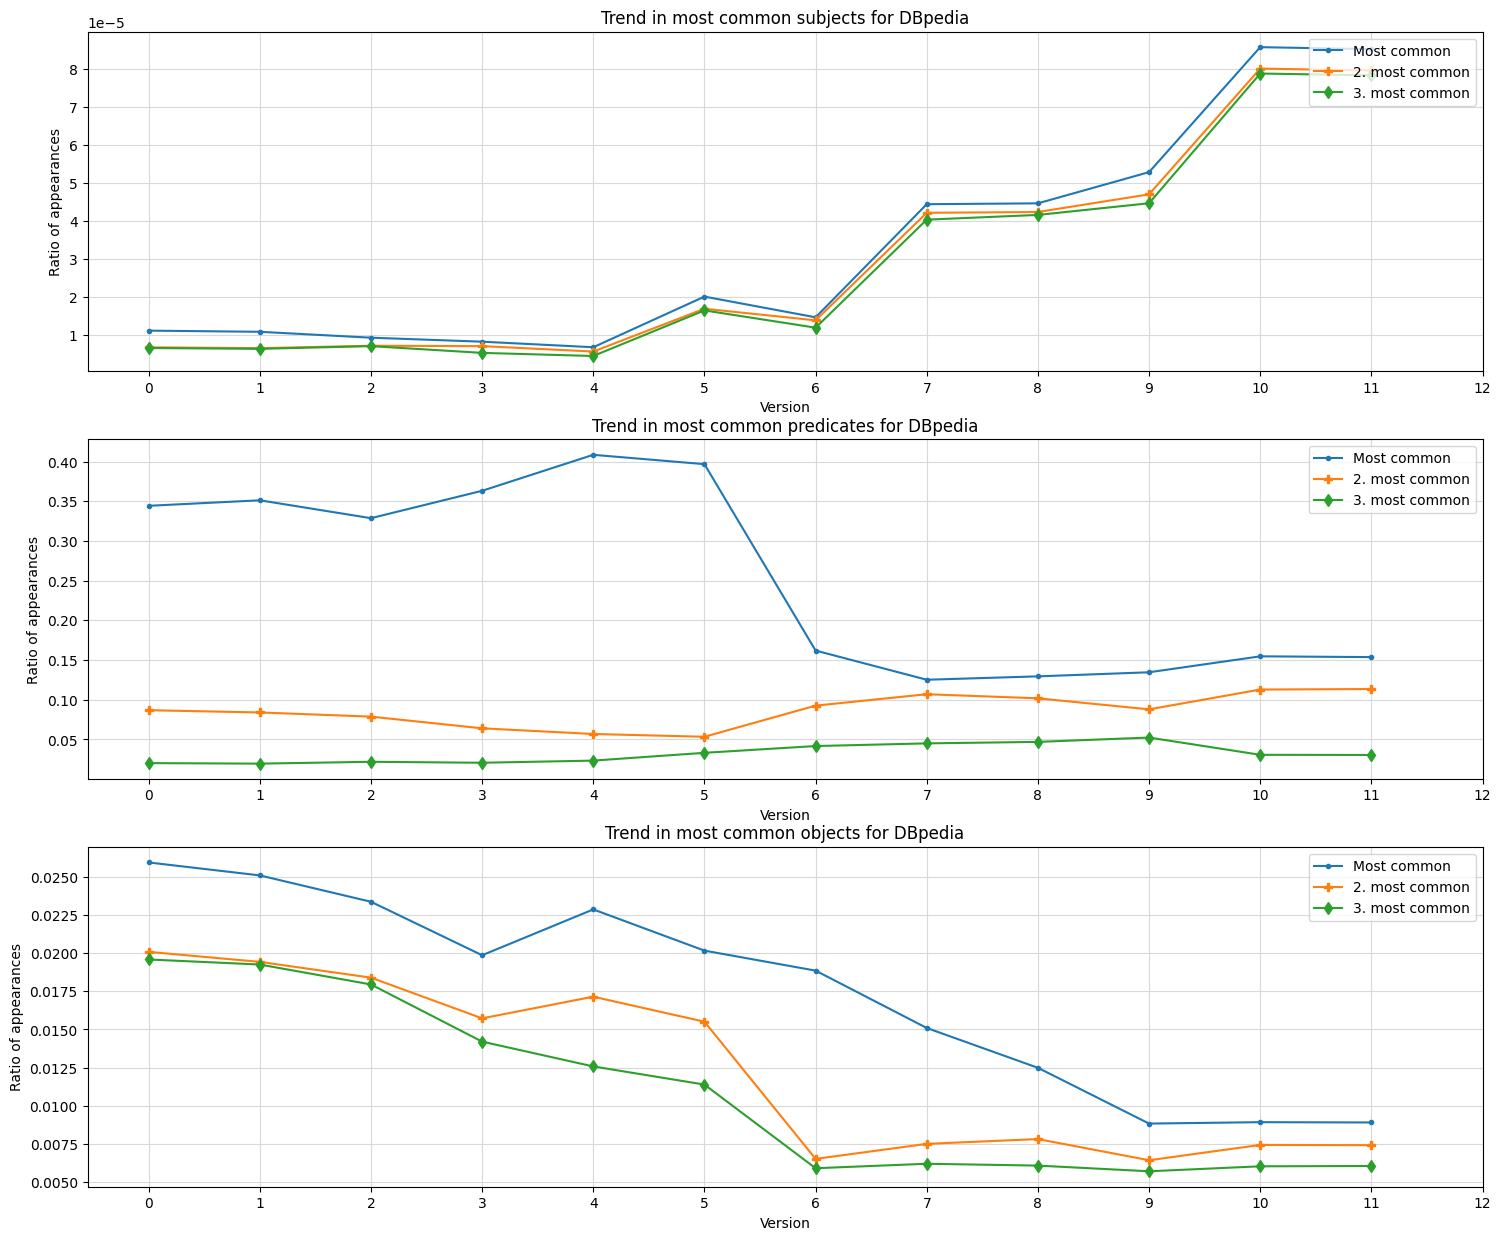

In [12]:
# If the visualization is too small, run the cell again
plt.rcParams["figure.figsize"] = [18, 15]
plt.subplot(3,1,1)
viz.top_trends('NotebookOutput/top_sub_.csv', 'basics.csv', graph_name, 'subjects', loc= 'upper right')
plt.subplot(3,1,2)
viz.top_trends('NotebookOutput/top_pre_.csv', 'basics.csv', graph_name, 'predicates', loc= 'upper right')
plt.subplot(3,1,3)
viz.top_trends('NotebookOutput/top_obj_.csv', 'basics.csv', graph_name, 'objects', loc= 'upper right')
plt.show()

# Structural measures of evolution
In this section we will analyze how the structural measures (growth ratio and density) of the graph change with each version

## Growth ratio
Given two graphs, $G_{i}$ and $G_{j}$, where $i$ and $j$ denote version number and $j>i$, the growth ratio from $G_{i}$ to $G_{i}$ is defined as
$$
growth(G_{i},G_{j})=\frac{|G_{j}|}{|G_{i}|}.
$$
With $|G_{i}|$ and $|G_{j}|$ denoting the size of the two graphs in number of triples respectively.

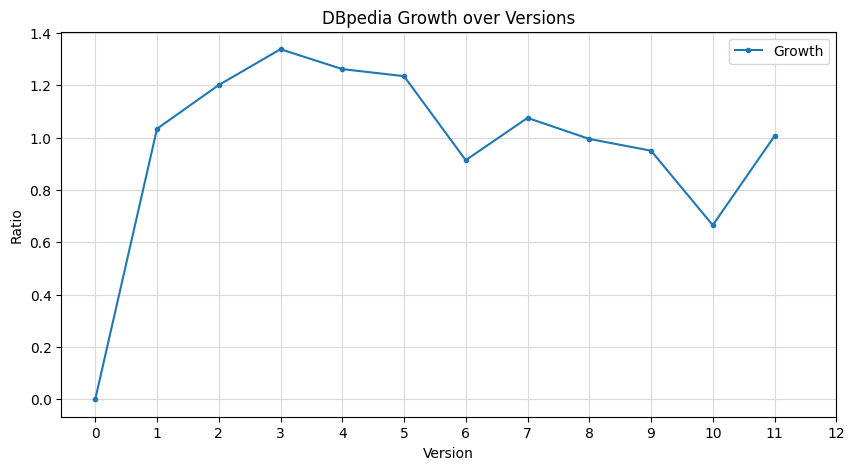

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.plot_parameters_over_versions(struc_cont_data, ['Growth'], ['.'], f"{graph_name} Growth over Versions", output_file_name= '')

## Density
Given a directed graph $G$ with edges $E$ and nodes $V$, the density, $D$, of $G$ is defined as
$$
D(G)=\frac{|E|}{|V|(|V|-1)}.
$$

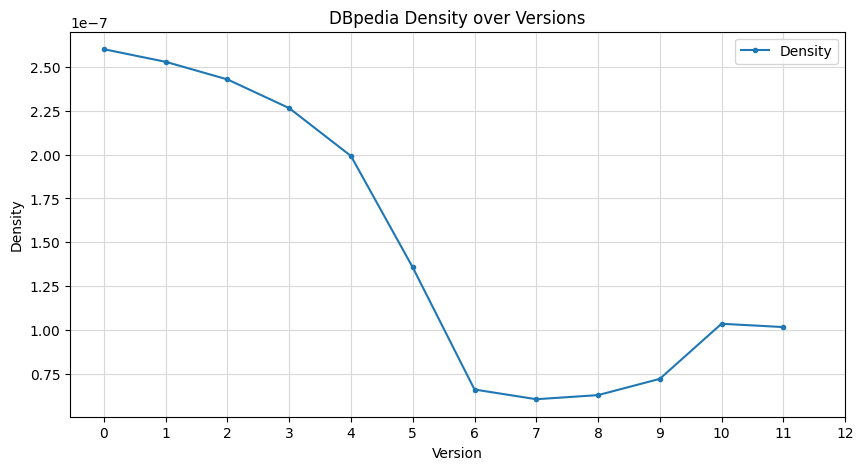

In [14]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['Density'], ['.'], 
    f"{graph_name} Density over Versions", 
    output_file_name= '', y_label= 'Density')

# Measuring evolution of content
In this section we analyze how the content of the graph changes with each version. Specifically through analyzing the knowledge degree, change ratio, vocabulary uniqueness and vocabulary dynamicity of the graphs.

## Knowledge degree
Given a directed graph $G$, with edges $E$ and nodes $V$, for a given node $v \in V$, the knowledge degree of $v$ is defined as 
$$
K_{D}(v)=d_{o}(v).
$$

The knowledge degree for the entire graph is then defined as

$$
K_{D}(G)=\frac{\sum_{v \in V}{K_{D}(v)}}{|V|}.
$$

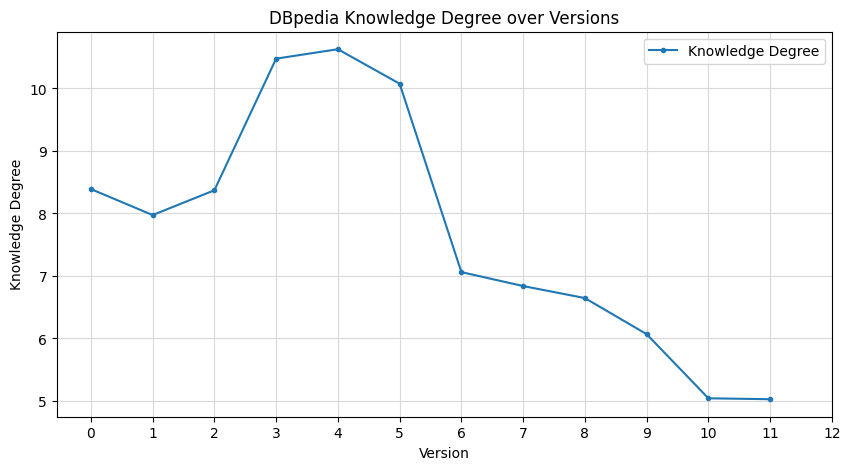

In [15]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['KD'], ['.'], 
    f"{graph_name} Knowledge Degree over Versions", 
    output_file_name= 'kd.png', y_label= 'Knowledge Degree', save_image= True)

## Change ratio
Consider two graphs, $G_{i}$ and $G_{j}$, where $i$ and $j$ denote version number and $j>i$.
Given the set of additions, $a^{+}_{i,j}$, and the set of removals, $r^{-}_{i,j}$, between the two versions of the graph, the change ratio is given by 
$$
\delta_{i,j}=\frac{|a^{+}_{i,j} \cup r^{-}_{i,j}|}{|G_{i}\cup G_{j}|}.
$$

Additionally, the insertion ratio, $\delta_{i,j}^{+}$, and deletion ratio, $\delta_{i,j}^{-}$, are defined by

$$
\delta^{+}_{i,j}=\frac{|a^{+}_{i,j}|}{|G_{i}|},
$$

$$
\delta^{-}_{i,j}=\frac{|r^{-}_{i,j}|}{|G_{i}|}.
$$

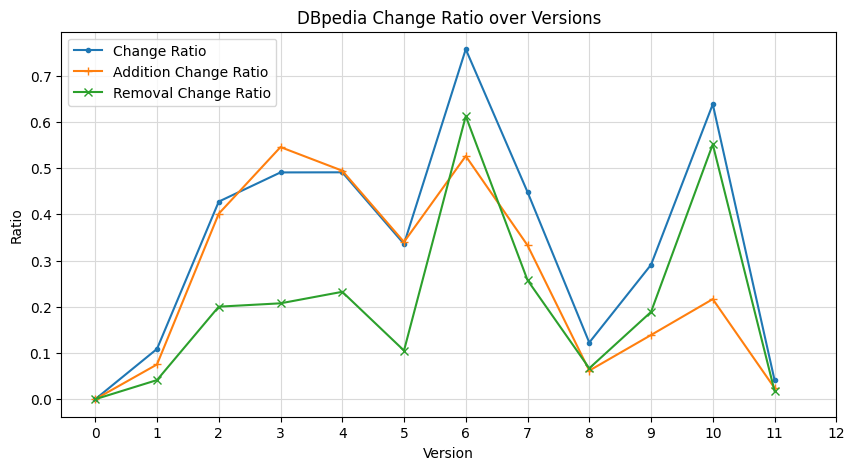

In [16]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['ChangeRatio', 'AddCR', 'RemCR'], ['.', '+', 'x'], 
    f"{graph_name} Change Ratio over Versions", 
    output_file_name= '')

## Vocabulary
For a version of a knowledge graph, $G_{i}$, the vocabulary set is the set of all unique subjects, $S_{G_{i}}$, predicates, $P_{G_{i}}$, and objects, $O_{G_{i}}$ in the knowledge graph.
The vocabulary set of $G_{i}$ is denoted $K(G_{i})$ and mathematically expressed as
$$
K(G_{i})=\{S_{G_{i}} \cup P_{G_{i}} \cup O_{G_{i}}\}.
$$

### Vocabulary uniqueness
Given a knowledge graph $G_{i}$ with the vocabulary set $K(G_{i})$, then the vocabulary uniqueness of $G_{i}$ is defined as
$$
\Psi(G_{i}) =\frac{|K(G_{i})|}{|G_{i}|}.
$$

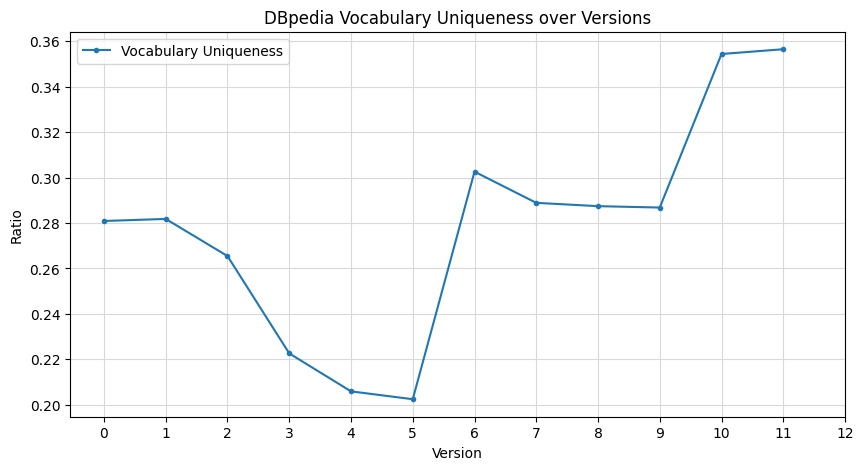

In [17]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['VocUni'], ['.'], 
    f"{graph_name} Vocabulary Uniqueness over Versions", 
    output_file_name= '')

### Vocabulary dynamicity
Given two versions of a knowledge graph, $G_{i}$ and $G_{j}$ with vocabulary sets $V(G_{i})$ and $V(G_{j})$ respectively, where $j>i$.
The vocabulary dynamicity is defined as
$$
vdyn_{i,j} = \frac{|(K(G_{i})\backslash K(G_{j})) \cup (K(G_{j})\backslash K(G_{i}))|}{|K(G_{i}) \cup K(G_{j})|}.
$$

Furthermore, the vocuabulary dynamicity for additions and removals are defined as

$$
vdyn^{+}_{i,j} = \frac{|(K(G_{j})\backslash K(G_{i}))|}{|K(G_{i}) \cup K(G_{j})|},
$$

$$
vdyn^{-}_{i,j} = \frac{|(K(G_{i})\backslash K(G_{j}))|}{|K(G_{i}) \cup V(G_{j})|}.
$$

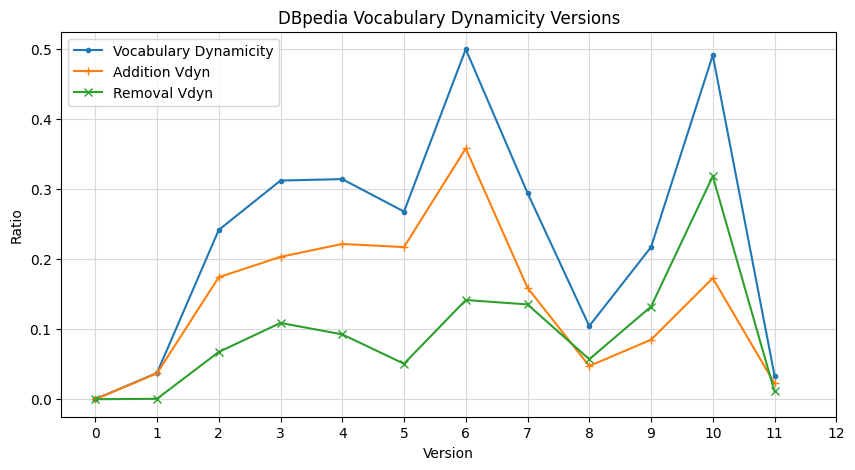

In [18]:
viz.plot_parameters_over_versions(
    struc_cont_data, ['Vdyn', 'AddVdyn', 'RemVdyn'], ['.', '+', 'x'], 
    f"{graph_name} Vocabulary Dynamicity Versions", 
    output_file_name= '')

# Measuring quality between versions
The quality measurements are centered around the ontologies of the graphs. As such, the measures of quality are based on the ideas that high quality means that as many of the classes and properties from the ontology are actually instantiated in the graphs. Similarly, if the graph has an ontology that is not overcomplicated with multiple inhertiance this is also considered high quality.

- **Instantiated class ratio**:
Given a knowledge graph $G_{i}$ and ontology $Ont(G_{i})$, consider $CL(Ont(G_{i}))$ the set of classes of the ontology and $ICL(Ont(G_{i}))$ the set of instantiated classes of the ontology.
The instantiated class ratio of $G_{i}$ is then defined as
$$
ICR(G_{i}) = \frac{|ICL(Ont(G_{i}))|}{|CL(Ont(G_{i}))|}.
$$

- **Instantiated property ratio**:
Given a knowledge graph $G_{i}$ and ontology $Ont(G_{i}))$, consider $P(Ont(G_{i}))$ the set of properties of the ontology and $IP(Ont(G_{i}))$ the set of instantiated properties of the ontology.
The instantiated property ratio of $G_{i}$ is then defined as
$$
IPR(G_{i}) = \frac{|IP(Ont(G_{i}))|}{|P(Ont(G_{i}))|}.
$$

- **Inverse multiple inheritance number**:
Given a knowledge graph $G_{i}$ and ontology $Ont(G_{i})$, consider $\Lambda(cl_{i})$ the set of superclasses of the class $cl_{i}$ and $CL(Ont(G_{i}))$ the set of classes of the ontology.
The inverse multiple inheritance number is then defined as
$$
q = \sum^{|CL(Ont(G_{i})|}_{i=1}{|\Lambda(cl_{i}))}|.
$$

$$
t = |CL(Ont(G_{i}))|.
$$

$$
IMI(G_{i}) = \frac{1}{\frac{q}{t}}.
$$

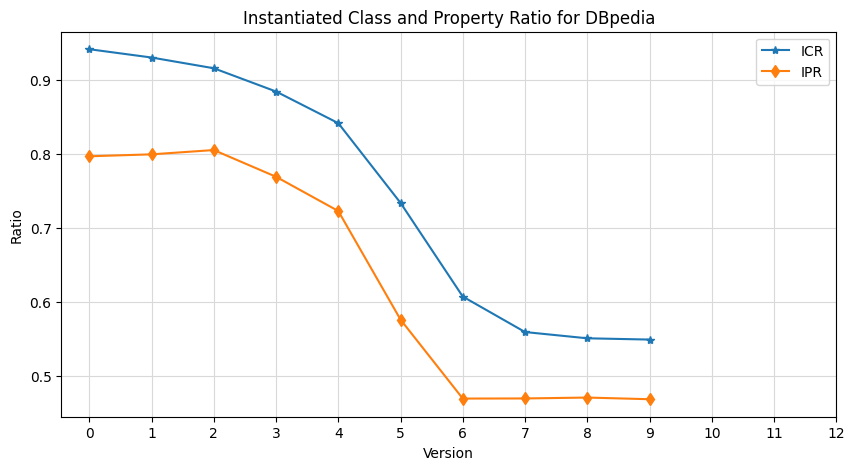

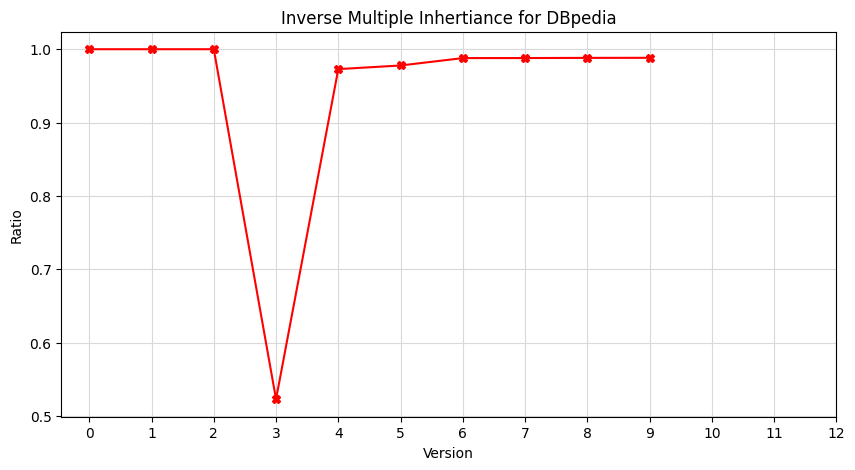

In [19]:
viz.quality_plots(name= graph_name, file_path= 'quality.csv')

## Class growth
Here we compare the number of self defined classes and the number of instantiated self defined classes. Self defined classes are non 3rd party classes i.e., the classes from the organization's own ontology.

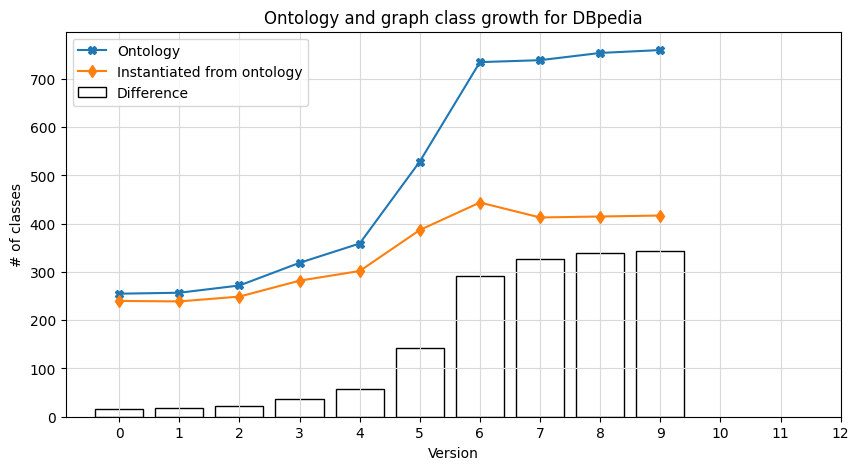

In [20]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.ont_growth(file_path= 'icr.csv', title_name= 'class', graph_name= graph_name)

## Property growth
Here we compare the number of self defined properties and the number of instantiated self defined properties. Self defined properties are non 3rd party properties i.e., the classes from the organization's own ontology.

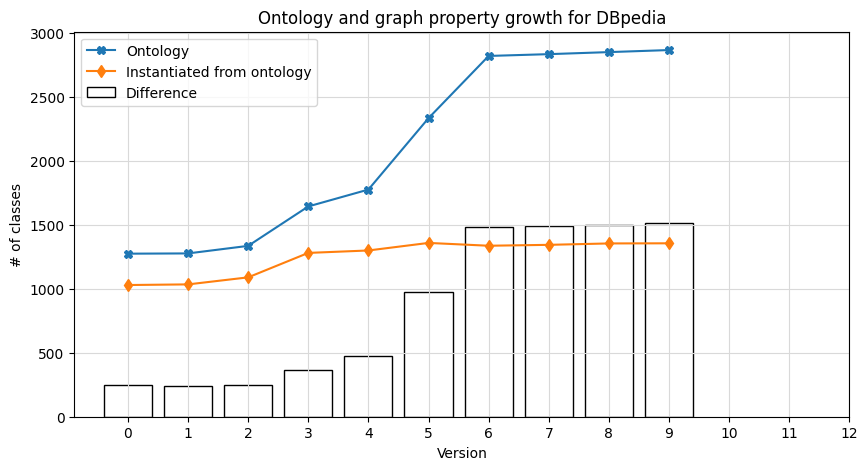

In [21]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.ont_growth(file_path= 'ipr.csv', title_name= 'property', graph_name= graph_name)

## Use of external vs. internal classes
Here we see how large a part of the classes instantiated are 3rd party classes, i.e., taken from ontologies which is not the organization's own ontology.

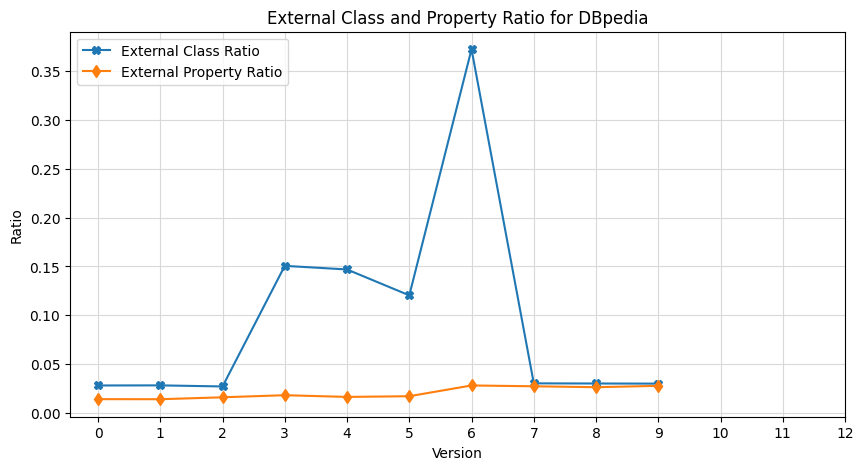

In [22]:
plt.rcParams["figure.figsize"] = [10, 5]
viz.external_ratio(class_path= 'icr.csv', property_path= 'ipr.csv', name= graph_name)